# Multi-Step Prediction of Duffing Oscillator

This notebook implements a multi-step LSTM model for predicting the dynamics of a Duffing oscillator.
Unlike recursive methods that predict one step at a time, this model predicts all future steps (e.g. 240 steps) in a single forward pass.

In [24]:
# Duffing Oscillator - LSTM Multi-Step Prediction (Non-Recursive)
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from glob import glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split

## Dataset Preparation

We slice simulation data into input-output pairs. The input is a history of `window_size` steps,
and the target is a sequence of `pred_horizon` future points.

This is more stable than recursive forecasting but less flexible if we want longer horizons than trained.

In [25]:
# Dataset class for multi-step prediction
class DuffingMultiStepDataset(Dataset):
    def __init__(self, data_dir, window_size=10, pred_horizon=10):
        self.window_size = window_size
        self.pred_horizon = pred_horizon
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        self.X, self.y = self.create_dataset_from_csv(data_dir)

    def create_dataset_from_csv(self, data_dir):
        all_csv_files = sorted(glob(os.path.join(data_dir, "*.csv")))
        #chaotic_files = [f for f in all_csv_files if "F1.0" in f and ("w1.2" in f or "w1.4" in f)]
        np.random.seed(42)
        #selected_files = np.random.choice(chaotic_files, size=min(100, len(chaotic_files)), replace=False)
        selected_files = np.random.choice(all_csv_files, size=min(100, len(all_csv_files)), replace=False)

        X_all, y_all = [], []

        for file in selected_files:
            df = pd.read_csv(file)
            df = df[df['t'] < 30.0].reset_index(drop=True)
            df = df.iloc[::5].reset_index(drop=True)

            series = df[["x", "v"]].values
            for i in range(len(series) - self.window_size - self.pred_horizon):
                input_seq = series[i:i + self.window_size]
                target_seq = series[i + self.window_size:i + self.window_size + self.pred_horizon]
                X_all.append(input_seq)
                y_all.append(target_seq)

        X_all = np.array(X_all)
        y_all = np.array(y_all)

        X_scaled = self.scaler_X.fit_transform(X_all.reshape(-1, 2)).reshape(X_all.shape)
        y_scaled = self.scaler_y.fit_transform(y_all.reshape(-1, 2)).reshape(y_all.shape)

        return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y_scaled, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## LSTM Model Architecture

The LSTM reads the input sequence and outputs a flat prediction vector,
which we reshape into `[horizon, 2]` (position and velocity at each step).

In [26]:
# LSTM model for multi-step prediction
class DuffingMultiLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2, pred_horizon=10, num_layers=1):
        super(DuffingMultiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * pred_horizon)
        self.pred_horizon = pred_horizon
        self.output_dim = output_dim

    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        pred = self.fc(last_out)
        return pred.view(-1, self.pred_horizon, self.output_dim)


## Training

We use MSE loss to train the model on simulated Duffing data.
Training and validation losses are tracked across epochs.

In [27]:
# Training function
def train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=50, device="cpu"):
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_pred = model(x_val)
                val_loss = loss_fn(val_pred, y_val)
                total_val_loss += val_loss.item()
        val_losses.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.6f} | Val Loss: {val_losses[-1]:.6f}")

    return train_losses, val_losses

In [28]:
def plot_multistep_prediction(y_true, y_pred, scaler_y):
    y_true = scaler_y.inverse_transform(y_true.reshape(-1, 2)).reshape(y_true.shape)
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 2)).reshape(y_pred.shape)
    steps = np.arange(y_true.shape[0])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(steps, y_true[:, 0], label="True x")
    plt.plot(steps, y_pred[:, 0], label="Pred x", linestyle="--")
    plt.title("Multi-step Prediction - Position")
    plt.xlabel("Step")
    plt.ylabel("x")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(steps, y_true[:, 1], label="True v")
    plt.plot(steps, y_pred[:, 1], label="Pred v", linestyle="--")
    plt.title("Multi-step Prediction - Velocity")
    plt.xlabel("Step")
    plt.ylabel("v")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Epoch 01 | Train Loss: 0.765831 | Val Loss: 0.682199
Epoch 02 | Train Loss: 0.648981 | Val Loss: 0.622988
Epoch 03 | Train Loss: 0.605989 | Val Loss: 0.592167
Epoch 04 | Train Loss: 0.583352 | Val Loss: 0.591784
Epoch 05 | Train Loss: 0.566738 | Val Loss: 0.555858
Epoch 06 | Train Loss: 0.543542 | Val Loss: 0.522563
Epoch 07 | Train Loss: 0.523495 | Val Loss: 0.517032
Epoch 08 | Train Loss: 0.500644 | Val Loss: 0.494522
Epoch 09 | Train Loss: 0.486728 | Val Loss: 0.485742
Epoch 10 | Train Loss: 0.472160 | Val Loss: 0.474853
Epoch 11 | Train Loss: 0.464135 | Val Loss: 0.473612
Epoch 12 | Train Loss: 0.447557 | Val Loss: 0.444143
Epoch 13 | Train Loss: 0.444489 | Val Loss: 0.437613
Epoch 14 | Train Loss: 0.432065 | Val Loss: 0.428747
Epoch 15 | Train Loss: 0.432676 | Val Loss: 0.455503
Epoch 16 | Train Loss: 0.427154 | Val Loss: 0.426968
Epoch 17 | Train Loss: 0.412376 | Val Loss: 0.418487
Epoch 18 | Train Loss: 0.408984 | Val Loss: 0.413516
Epoch 19 | Train Loss: 0.403131 | Val Loss: 0.

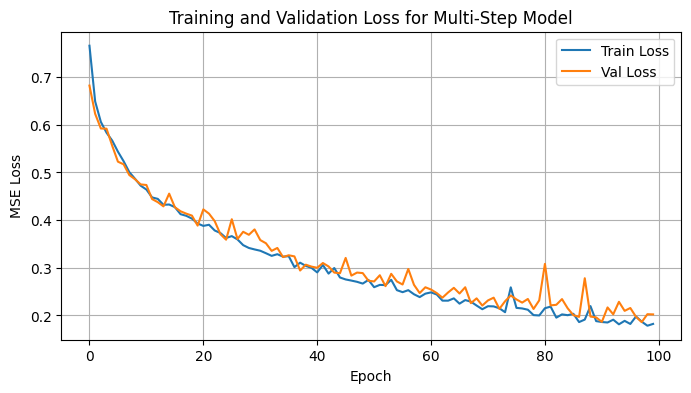

In [29]:
# === Pipeline ===
data_dir = "../data/raw/"
window_size = 80
pred_horizon = 240

dataset = DuffingMultiStepDataset(data_dir, window_size, pred_horizon)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = DuffingMultiLSTM(pred_horizon=pred_horizon)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
train_losses, val_losses = train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=100)
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss for Multi-Step Model")
plt.legend()
plt.grid(True)
plt.show()


## Prediction on Test Sample

We select one test sequence, predict 240 future steps, and compare the result to the ground truth
for both position `x` and velocity `v`.

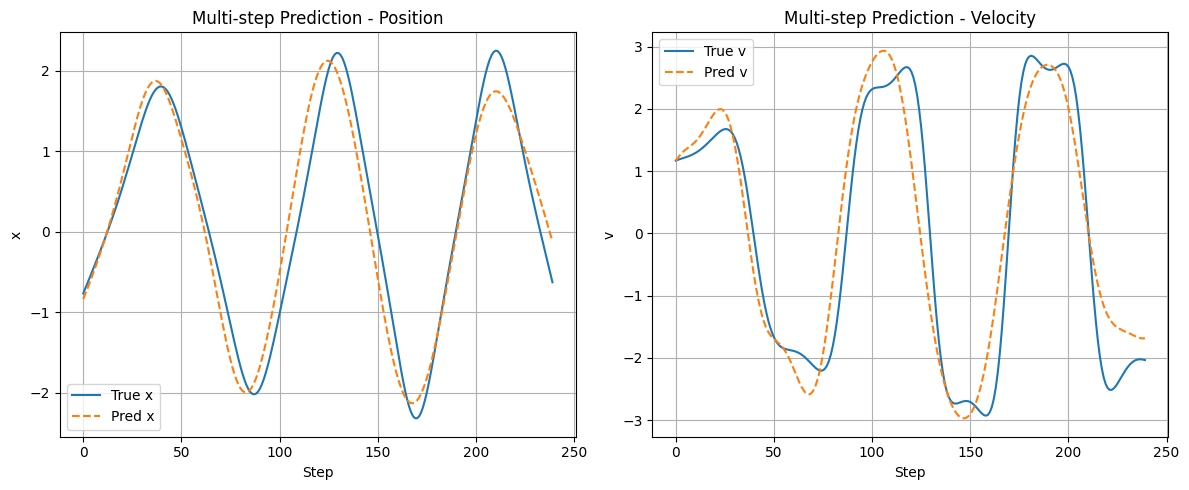

In [30]:
# Plot prediction from test set
model.eval()
with torch.no_grad():
    sample_x, sample_y = test_dataset[30]
    pred_y = model(sample_x.unsqueeze(0)).squeeze(0).cpu().numpy()
    true_y = sample_y.cpu().numpy()
    plot_multistep_prediction(true_y, pred_y, dataset.scaler_y)

## Phase Portrait Comparison

Plotting predicted vs true motion in phase space `(x, v)` gives insight into the model's learned dynamics.

Correct structure here implies the model captured nonlinear oscillation behavior.

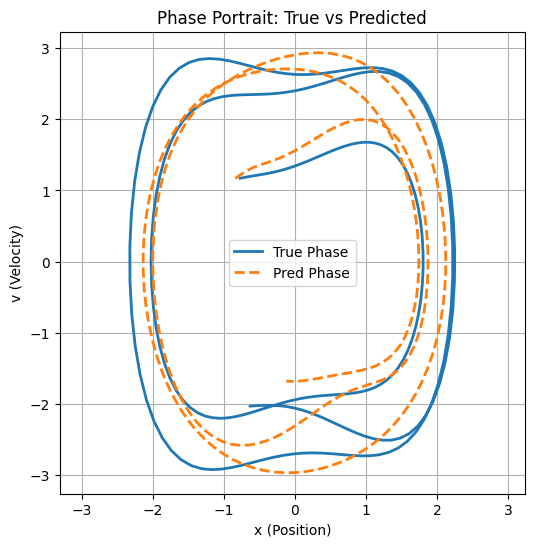

In [31]:
# Plot phase portrait of predicted vs true trajectory
import matplotlib.pyplot as plt

# Inverse transform predicted and true values
true_traj = dataset.scaler_y.inverse_transform(true_y)
pred_traj = dataset.scaler_y.inverse_transform(pred_y)

plt.figure(figsize=(6, 6))
plt.plot(true_traj[:, 0], true_traj[:, 1], label="True Phase", linewidth=2)
plt.plot(pred_traj[:, 0], pred_traj[:, 1], label="Pred Phase", linestyle="--", linewidth=2)
plt.xlabel("x (Position)")
plt.ylabel("v (Velocity)")
plt.title("Phase Portrait: True vs Predicted")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


## Animated Phase Space Motion

This animation shows both predicted and true trajectories evolving over time in phase space.
Visually highlights where the prediction starts to diverge or maintain the correct structure.

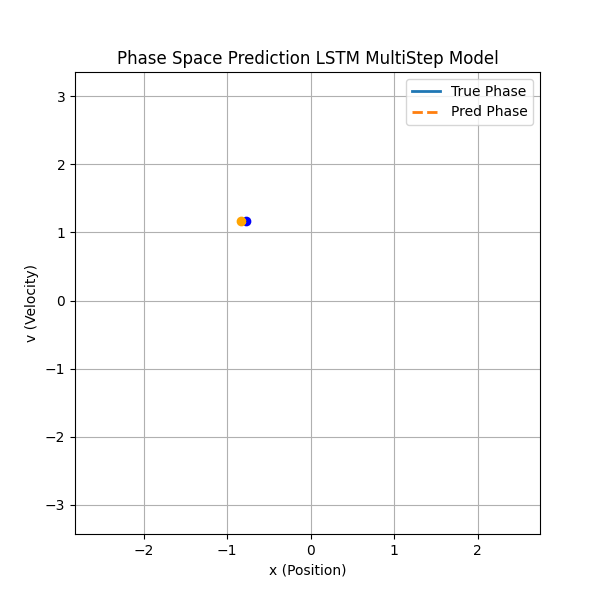

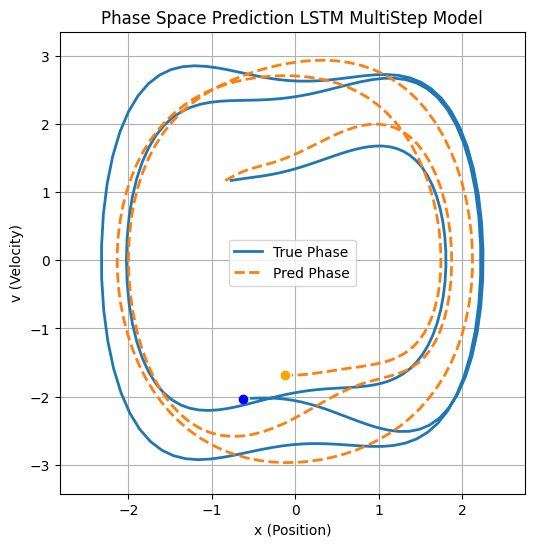

In [32]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(np.min(true_traj[:, 0]) - 0.5, np.max(true_traj[:, 0]) + 0.5)
ax.set_ylim(np.min(true_traj[:, 1]) - 0.5, np.max(true_traj[:, 1]) + 0.5)
ax.set_xlabel("x (Position)")
ax.set_ylabel("v (Velocity)")
ax.set_title("Phase Space Prediction LSTM MultiStep Model")
ax.grid(True)

# Phase trajectory lines
true_line, = ax.plot([], [], lw=2, label="True Phase")
pred_line, = ax.plot([], [], lw=2, linestyle='--', label="Pred Phase")

# Moving markers for the particles
true_dot, = ax.plot([], [], 'o', color='blue', markersize=6)
pred_dot, = ax.plot([], [], 'o', color='orange', markersize=6)

ax.legend()

def init():
    true_line.set_data([], [])
    pred_line.set_data([], [])
    true_dot.set_data([], [])
    pred_dot.set_data([], [])
    return true_line, pred_line, true_dot, pred_dot

def update(frame):
    true_line.set_data(true_traj[:frame, 0], true_traj[:frame, 1])
    pred_line.set_data(pred_traj[:frame, 0], pred_traj[:frame, 1])
    true_dot.set_data([true_traj[frame, 0]], [true_traj[frame, 1]])
    pred_dot.set_data([pred_traj[frame, 0]], [pred_traj[frame, 1]])
    return true_line, pred_line, true_dot, pred_dot


ani = animation.FuncAnimation(
    fig, update, frames=len(true_traj), init_func=init,
    blit=True, interval=30
)

# Save as a .gif
ani.save("duffing_phase_motion.gif", writer="pillow", fps=30)

# Display inline in Jupyter
from IPython.display import Image
Image(filename="duffing_phase_motion.gif")


## MSE Per Timestep

We compute the Mean Squared Error (MSE) between predicted and true values at each timestep
to understand how prediction accuracy evolves across the prediction horizon.

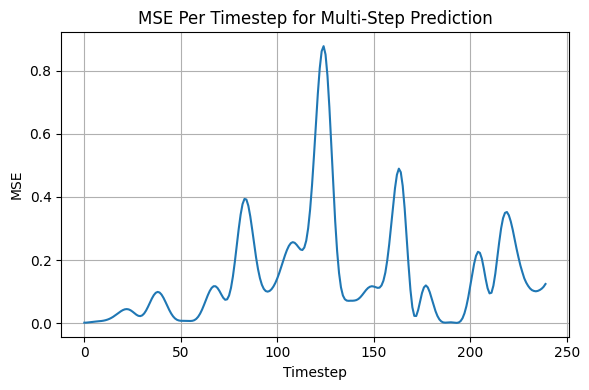

In [33]:
from sklearn.metrics import mean_squared_error

mse_per_step = [
    mean_squared_error(true_y[i], pred_y[i])
    for i in range(pred_horizon)
]

plt.figure(figsize=(6, 4))
plt.plot(mse_per_step)
plt.title("MSE Per Timestep for Multi-Step Prediction")
plt.xlabel("Timestep")
plt.ylabel("MSE")
plt.grid(True)
plt.tight_layout()
plt.show()

## Error Distribution Across Multiple Samples

We evaluate the model across multiple test sequences to compute
the average and standard deviation of prediction errors per timestep.
This shows both performance and uncertainty.

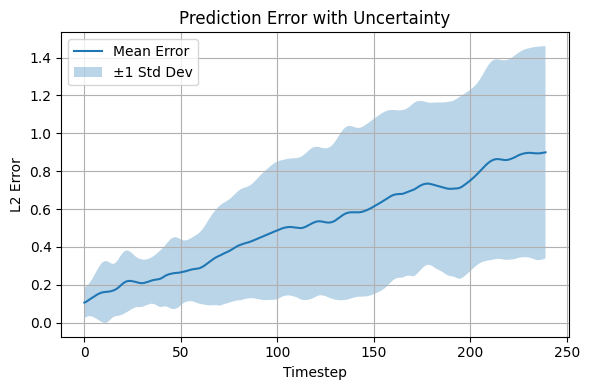

In [34]:
n_samples = 100  # number of test samples to evaluate
errors_all = []

model.eval()
with torch.no_grad():
    for i in range(n_samples):
        x_sample, y_true = test_dataset[i]
        y_pred = model(x_sample.unsqueeze(0)).squeeze(0).cpu().numpy()
        y_true = y_true.cpu().numpy()
        errors = np.linalg.norm(y_true - y_pred, axis=1)
        errors_all.append(errors)

errors_all = np.array(errors_all)  # shape: [n_samples, pred_horizon]

mean_error = np.mean(errors_all, axis=0)
std_error = np.std(errors_all, axis=0)

# Plot with error bands
plt.figure(figsize=(6, 4))
plt.plot(mean_error, label="Mean Error")
plt.fill_between(np.arange(pred_horizon), mean_error - std_error, mean_error + std_error, alpha=0.3, label="±1 Std Dev")
plt.title("Prediction Error with Uncertainty")
plt.xlabel("Timestep")
plt.ylabel("L2 Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Example:
# true_y and pred_y should be NumPy arrays of shape (num_samples, pred_horizon, 2)
# If you're evaluating single-step recursive predictions: shape can be (num_samples, 2)

# Flatten for metrics if multi-step
true_flat = true_y.reshape(-1, true_y.shape[-1])
pred_flat = pred_y.reshape(-1, pred_y.shape[-1])

# Compute metrics
mse = mean_squared_error(true_flat, pred_flat)
r2 = r2_score(true_flat, pred_flat)
mae = mean_absolute_error(true_flat, pred_flat)

print(f"MSE: {mse:.6f}")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.6f}")


MSE: 0.153326
R² Score: 0.9122
MAE: 0.300818
